In [1]:
## The input shape of the LSTM layer is 700 × 30, 700 × 60 or 700 × 90 
## where 700 is the amount of music
## The output of the LSTM layer is 700 × 128, 128 is the number of units in LSTM layer
## Additionally, the activation functions used in this project are the hyperbolic tangen
## and sigmoid

In [62]:
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from keras.layers import Bidirectional
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import regularizers
import pandas as pd
import sklearn as skl
import sklearn.model_selection as skm
from keras.optimizers import Adam
from keras.models import Model
import numpy as np
from keras import backend as K
import import_ipynb
import SVM_KNN as sknn
import matplotlib.pyplot as plt

In [2]:
GTZAN_DIR = '/Users/nkkaushal/Documents/Fall22/ECS_271/Project/dataset/GTZAN_data/'
features = pd.read_csv(GTZAN_DIR+"zcr_mfcc_3_sec.csv")

In [84]:
dir_for_plotting = "/Users/nkkaushal/Documents/Fall22/ECS_271/Project/dataset/data_for_plotting"

In [33]:
def get_test_train_split(X, Y, norm, shuffle, test_size):

    if(norm == 1):
        scaler = skl.preprocessing.StandardScaler(copy=False)
        scaler.fit_transform(X)
    
    X_train, X_test, Y_train, Y_test = skm.train_test_split(X, Y, test_size=test_size, random_state=42)

    if(shuffle == 1):
        # Be sure training samples are shuffled.
        X_train, Y_train = skl.utils.shuffle(X_train, Y_train, random_state=42)
        X_test, Y_test = skl.utils.shuffle(X_test, Y_test, random_state=42)

    return [X_train, X_test, Y_train, Y_test]

In [73]:
def plot_graph(accs, losses):

    plt.plot(range(len(accs[0])), accs[0], color='b', label="Train")
    plt.plot(range(len(accs[1])), accs[1], color='g', label = "Validation")
    plt.title(f"Graph of Accuracy VS Number_Of_Epochs")
    plt.ylabel(f"Accuracy")
    plt.xlabel("Number_Of_Epochs")
    plt.show()

    plt.plot(range(len(losses[0])), losses[0], color='b', label = "Train")
    plt.plot(range(len(losses[1])), losses[1], color='g', label = "Validation")
    plt.title(f"Graph of Loss VS Number_Of_Epochs")
    plt.ylabel(f"Loss")
    plt.xlabel("Number_Of_Epochs")
    plt.show()

In [89]:
def get_deep_features(model, train, test):
    intermediate_layer_model = Model(inputs=model.input,
                                outputs=model.layers[1].output)
    intermediate_output_train = intermediate_layer_model(train)
    intermediate_output_test = intermediate_layer_model(test)

    return [intermediate_output_train, intermediate_output_test]

In [34]:
X_ZCR = features[['ZRC' + str(ind) for ind in range(1,31)]]
X_MFCC = features[['MFCC' + str(ind) for ind in range(1,61)]]
X_ZCR_MFCC = features[['ZRC' + str(ind) for ind in range(1,31)]+['MFCC' + str(ind) for ind in range(1,61)]]
Y = features['label']

genre_list = Y.unique().tolist()

In [35]:
X_ZCR_MFCC.shape

(9990, 90)

In [36]:
def one_hot(Y_genre_strings):
    y_one_hot = np.zeros((Y_genre_strings.shape[0], len(genre_list)))
    for i, genre_string in enumerate(Y_genre_strings):
        index = genre_list.index(genre_string)
        y_one_hot[i, index] = 1
    return y_one_hot

In [35]:
Y_one_hot = one_hot(Y)
X_train_zcr, X_test_zcr, Y_train_zcr, Y_test_zcr = get_test_train_split(X_ZCR, Y_one_hot)
X_train_zcr = X_train_zcr.to_numpy().reshape((X_train_zcr.shape[0], X_train_zcr.shape[1], 1))
X_test_zcr = X_test_zcr.to_numpy().reshape((X_test_zcr.shape[0], X_test_zcr.shape[1], 1))
# Y_train_zcr = Y_train_zcr.reshape((Y_train_zcr.shape[0], Y_train_zcr.shape[1], 1))
input_shape = (X_train_zcr.shape[1], X_train_zcr.shape[2])

In [37]:
# Y_one_hot = one_hot(Y)
X_train_mfcc, X_test_mfcc, Y_train_mfcc, Y_test_mfcc = get_test_train_split(X_MFCC, Y, norm = 1, shuffle = 1, test_size = 0.3)
Y_one_hot_train = one_hot(Y_train_mfcc)

X_test_mfcc, X_val_mfcc, Y_test_mfcc, Y_val_mfcc = get_test_train_split(X_test_mfcc, Y_test_mfcc, norm = 0, shuffle = 0, test_size = 0.33)
Y_one_hot_test = one_hot(Y_test_mfcc)
Y_one_hot_val = one_hot(Y_val_mfcc)

X_train_mfcc = X_train_mfcc.to_numpy().reshape((X_train_mfcc.shape[0], X_train_mfcc.shape[1], 1))
X_test_mfcc = X_test_mfcc.to_numpy().reshape((X_test_mfcc.shape[0], X_test_mfcc.shape[1], 1))
X_val_mfcc = X_val_mfcc.to_numpy().reshape((X_val_mfcc.shape[0], X_val_mfcc.shape[1], 1))
# Y_train_zcr = Y_train_zcr.reshape((Y_train_zcr.shape[0], Y_train_zcr.shape[1], 1))
input_shape = (X_train_mfcc.shape[1], X_train_mfcc.shape[2])

In [38]:
print(X_train_mfcc.shape, X_test_mfcc.shape, X_val_mfcc.shape)

(6993, 60, 1) (2007, 60, 1) (990, 60, 1)


In [47]:
from collections import Counter

print(Counter(Y_train_mfcc))
print(Counter(Y_test_mfcc))
print(Counter(Y_val_mfcc))

Counter({'pop': 733, 'jazz': 714, 'country': 711, 'disco': 698, 'rock': 698, 'metal': 697, 'classical': 690, 'hiphop': 687, 'reggae': 684, 'blues': 681})
Counter({'reggae': 220, 'hiphop': 212, 'blues': 210, 'disco': 203, 'classical': 202, 'metal': 198, 'country': 197, 'jazz': 196, 'rock': 194, 'pop': 175})
Counter({'blues': 109, 'rock': 106, 'classical': 106, 'metal': 105, 'hiphop': 99, 'disco': 98, 'reggae': 96, 'pop': 92, 'jazz': 90, 'country': 89})


In [274]:
Y_one_hot = one_hot(Y)
X_train_zcr_mfcc, X_test_zcr_mfcc, Y_train_zcr_mfcc, Y_test_zcr_mfcc = get_test_train_split(X_ZCR_MFCC, Y_one_hot, norm)
X_train_zcr_mfcc = X_train_zcr_mfcc.to_numpy().reshape((X_train_zcr_mfcc.shape[0], 1, X_train_zcr_mfcc.shape[1]))
X_test_zcr_mfcc = X_test_zcr_mfcc.to_numpy().reshape((X_test_zcr_mfcc.shape[0], 1, X_test_zcr_mfcc.shape[1]))
# Y_train_zcr = Y_train_zcr.reshape((Y_train_zcr.shape[0], Y_train_zcr.shape[1], 1))
input_shape = (X_train_zcr_mfcc.shape[1], X_train_zcr_mfcc.shape[2])

In [110]:
Y_train_zcr.shape

(700, 10)

In [52]:
inputs = Input(input_shape)
# lstm1 = LSTM(units=64, return_sequences=True)(inputs)
lstm = LSTM(units=128, return_sequences=False, dropout=0.05, recurrent_dropout=0.35)(inputs)
# lstm1 = LSTM(units=128, activation = 'relu', return_sequences=False)(lstm)
dense = Dense(units=10, activation="softmax")(lstm)

model = Model(inputs, dense)

In [53]:
opt = Adam()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               66560     
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 67,850
Trainable params: 67,850
Non-trainable params: 0
_________________________________________________________________


In [54]:
print("Training ...")
batch_size = 45 # num of training examples per minibatch
num_epochs = 100
model.fit(
    X_train_mfcc,
    Y_one_hot_train,
    validation_data=(X_val_mfcc, Y_one_hot_val),
    batch_size=batch_size,
    epochs=num_epochs,
)

Training ...
Epoch 1/100


2022-11-22 20:03:42.047876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


156/156 [==============================] - ETA: 0s - loss: 2.0616 - accuracy: 0.2329

2022-11-22 20:26:06.002948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


156/156 [==============================] - 1352s 9s/step - loss: 2.0616 - accuracy: 0.2329 - val_loss: 1.8676 - val_accuracy: 0.3232
Epoch 2/100
156/156 [==============================] - 1343s 9s/step - loss: 1.8654 - accuracy: 0.3202 - val_loss: 1.7619 - val_accuracy: 0.3747
Epoch 3/100
156/156 [==============================] - 1329s 9s/step - loss: 1.7872 - accuracy: 0.3545 - val_loss: 1.6756 - val_accuracy: 0.3939
Epoch 4/100
156/156 [==============================] - 1329s 9s/step - loss: 1.7220 - accuracy: 0.3811 - val_loss: 1.6032 - val_accuracy: 0.4343
Epoch 5/100
156/156 [==============================] - 976s 6s/step - loss: 1.6725 - accuracy: 0.3970 - val_loss: 1.5545 - val_accuracy: 0.4384
Epoch 6/100
156/156 [==============================] - 922s 6s/step - loss: 1.6059 - accuracy: 0.4210 - val_loss: 1.5087 - val_accuracy: 0.4556
Epoch 7/100
156/156 [==============================] - 940s 6s/step - loss: 1.5706 - accuracy: 0.4324 - val_loss: 1.4218 - val_accuracy: 0.5000


In [94]:
mfcc_deep_train, mfcc_deep_test = get_deep_features(model, X_train_mfcc, X_test_mfcc)

In [79]:
train_acc_deep_mfcc = model.history.history['accuracy']
train_loss_deep_mfcc = model.history.history['loss']
val_acc_deep_mfcc = model.history.history['val_accuracy']
val_loss_deep_mfcc = model.history.history['val_loss']

In [88]:
np.save(dir_for_plotting+"/train_acc_deep_mfcc", train_acc_deep_mfcc)
np.save(dir_for_plotting+"/train_loss_deep_mfcc", train_loss_deep_mfcc)
np.save(dir_for_plotting+"/val_acc_deep_mfcc", val_acc_deep_mfcc)
np.save(dir_for_plotting+"/val_loss_deep_mfcc", val_loss_deep_mfcc)

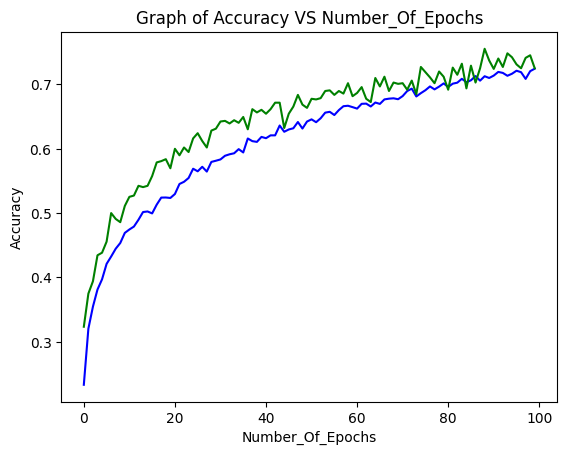

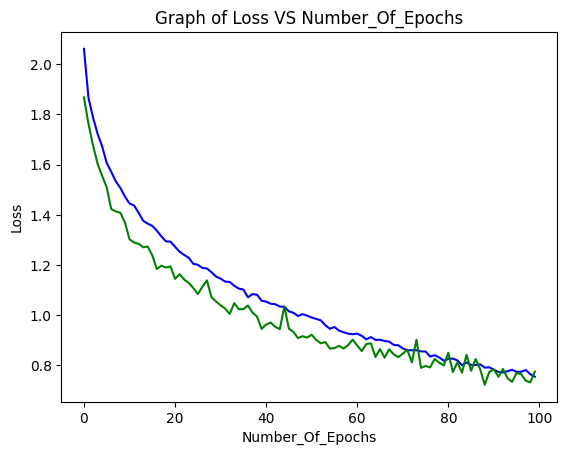

In [80]:
plot_graph([train_acc_deep_mfcc, val_acc_deep_mfcc], [train_loss_deep_mfcc, val_loss_deep_mfcc])

In [95]:
deep_mfcc_svm_score = sknn.SVM_score(mfcc_deep_train, Y_train_mfcc, mfcc_deep_test, Y_test_mfcc)
deep_mfcc_knn_score = sknn.KNN_score(mfcc_deep_train, Y_train_mfcc, mfcc_deep_test, Y_test_mfcc)

In [96]:
print("SVM score using deep mfcc features : ", deep_mfcc_svm_score)
print("KNN score using deep mfcc features : ", deep_mfcc_knn_score)

SVM score using deep mfcc features :  0.7324364723467862
KNN score using deep mfcc features :  0.7269556552067763


In [55]:
model.save('LSTM_model_Nov22.h')

INFO:tensorflow:Assets written to: LSTM_model_Nov22.h/assets


In [148]:
test_loss, test_acc = model.evaluate(X_test_zcr, Y_test_zcr, verbose=2)

2022-11-03 22:04:54.423506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-03 22:04:54.478340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 - 0s - loss: 1.0753 - accuracy: 0.1767 - 447ms/epoch - 45ms/step


In [21]:
test_loss, test_acc = model.evaluate(X_test_mfcc, Y_one_hot_test, verbose=2)

2022-11-09 14:31:26.849565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 - 4s - loss: 1.5619 - accuracy: 0.4600 - 4s/epoch - 383ms/step


In [ ]:
test_loss, test_acc = model.evaluate(X_test_zcr_mfcc, Y_test_zcr_mfcc, verbose=2)

2022-11-04 03:45:55.908381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-04 03:45:56.003917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-04 03:45:56.101725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 - 1s - loss: 0.8142 - accuracy: 0.5967 - 943ms/epoch - 94ms/step


: 